# 🚨 Fraud Detection Model
### Identify Suspicious Claim Activities Using Demographic, Policy, and Risk Data

This notebook builds a supervised ML model to detect potential fraudulent behavior using:
- Demographics  
- Policy & financial data  
- Risk indicators  
- Claim history  
- Behavioral features  

A synthetic fraud label is generated using realistic business rules.

## 📦 Import Required Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

## 📁 Load Processed Customer Dataset

In [2]:
df = pd.read_csv("../data/processed_customer_dataset.csv")
df.head()

,Customer ID,Age,Income Level,Location,Claim History,Coverage Amount,Premium Amount,Deductible,Risk Profile,Previous Claims History,...,Driving Record_Major Violations,Driving Record_Minor Violations,Life Events_Divorce,Life Events_Job Change,Life Events_Marriage,Life Events_Retirement,Segmentation Group_Segment2,Segmentation Group_Segment3,Segmentation Group_Segment4,Segmentation Group_Segment5
0,1.161055,-1.401980,-0.333617,-0.636458,1.416283,-0.469361,-0.213640,0.871878,-0.525889,1.212606,...,False,False,False,True,False,False,False,False,False,True
1,1.537483,-1.203033,-0.780348,0.377921,-1.441872,1.071729,-0.822588,0.587999,-0.525889,0.301218,...,False,False,False,False,False,True,False,False,False,True
2,-1.481328,-1.004085,-0.241996,-0.020824,0.844652,1.048219,1.080474,0.886162,0.354840,-0.610170,...,False,False,False,False,False,False,False,True,False,False
3,0.879390,-1.600928,-0.528975,-1.216311,1.416283,1.099966,1.025256,1.252169,1.235569,-1.521558,...,False,False,False,True,False,False,False,True,False,False
4,1.274459,-1.269349,-1.199821,1.541248,0.273021,-0.469722,-1.359210,-1.754449,-1.406619,1.212606,...,True,False,False,False,False,False,True,False,False,False


## 🚨 Add Synthetic Fraud Label (Fraud_Flag)

Fraud probability increases when:
- Low credit score  
- Poor driving record  
- High risk profile  
- Multiple previous claims  
- High coverage + low deductible  
- High premium relative to income  

In [3]:
df['Fraud_Flag'] = 0

# Rule 1: Low credit score
low_credit = [col for col in df.columns if "Credit Score" in col][0]
df.loc[df[low_credit] < df[low_credit].quantile(0.25), 'Fraud_Flag'] += 1

# Rule 2: Poor driving record
driving_cols = [col for col in df.columns if "Driving Record" in col]
for col in driving_cols:
    df.loc[df[col] == 1, 'Fraud_Flag'] += 1  # assuming 1 = Poor after encoding

# Rule 3: High risk profile
risk_cols = [col for col in df.columns if "Risk Profile" in col]
for col in risk_cols:
    df.loc[df[col] == 1, 'Fraud_Flag'] += 1  # High risk encoded as 1

# Rule 4: Multiple previous claims
claims_cols = [col for col in df.columns if "Previous Claims History" in col]
df.loc[df[claims_cols[0]] > df[claims_cols[0]].median(), 'Fraud_Flag'] += 1

# Rule 5: High coverage + low deductible
coverage = [col for col in df.columns if "Coverage Amount" in col][0]
deductible = [col for col in df.columns if "Deductible" in col][0]

df.loc[
    (df[coverage] > df[coverage].quantile(0.85)) &
    (df[deductible] < df[deductible].quantile(0.15)),
    'Fraud_Flag'
] += 1

# Convert to binary label
df['Fraud_Flag'] = (df['Fraud_Flag'] >= 2).astype(int)

df['Fraud_Flag'].value_counts()

Fraud_Flag
0    29980
1    23523
Name: count, dtype: int64

## 🧠 Fraud Scoring Logic (Visual)

![Fraud Flag Flowchart](../visuals/fraud_flag_flowchart.png)

## 📊 Fraud Distribution

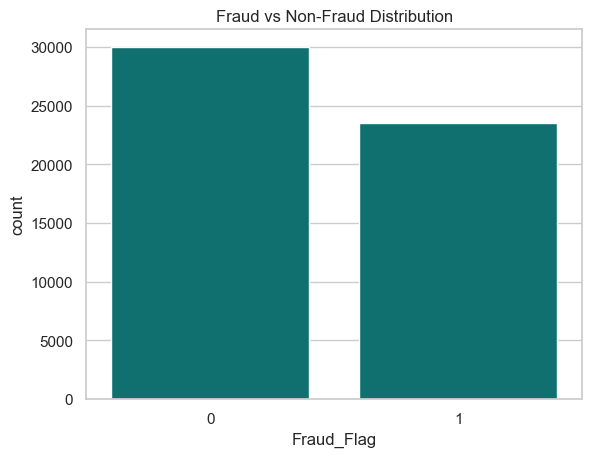

In [4]:
sns.countplot(x='Fraud_Flag', data=df, color="teal")
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

## ✂️ Train-Test Split

In [5]:
X = df.drop(columns=['Fraud_Flag'])
y = df['Fraud_Flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((40127, 2123), (13376, 2123))

## 🤖 Train ML Models
Models:
- Logistic Regression
- Random Forest
- Decision Tree
- KNN

In [6]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight="balanced",
        random_state=42
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=3,
        algorithm='kd_tree',
        weights='distance',
        leaf_size=30
    )
}

pca = PCA(n_components=20, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

results = {}

for name, model in models.items():
    if name == "KNN":
        model.fit(X_train_pca, y_train)
        preds = model.predict(X_test_pca)
        proba = model.predict_proba(X_test_pca)[:, 1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)[:, 1]

    
    results[name] = {
        "model": model,
        "preds": preds,
        "proba": proba
    }
    
    print(f"\n{name} Results")
    print(classification_report(y_test, preds))


Logistic Regression Results
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      7495
           1       0.84      0.84      0.84      5881

    accuracy                           0.86     13376
   macro avg       0.85      0.86      0.85     13376
weighted avg       0.86      0.86      0.86     13376


Random Forest Results
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7495
           1       0.96      0.98      0.97      5881

    accuracy                           0.97     13376
   macro avg       0.97      0.97      0.97     13376
weighted avg       0.97      0.97      0.97     13376


Decision Tree Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7495
           1       1.00      1.00      1.00      5881

    accuracy                           1.00     13376
   macro avg       1.00      1.00      1.00     13376

## 🔍 Confusion Matrices

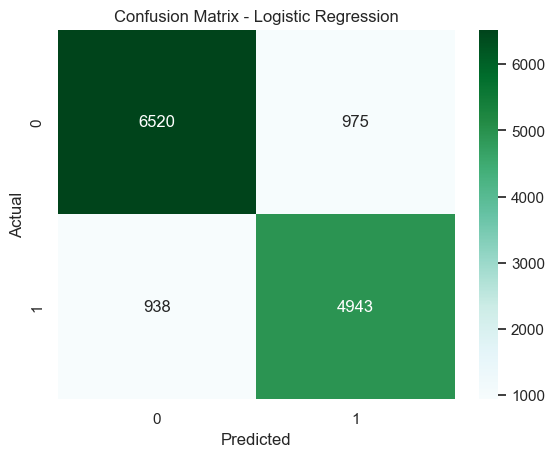

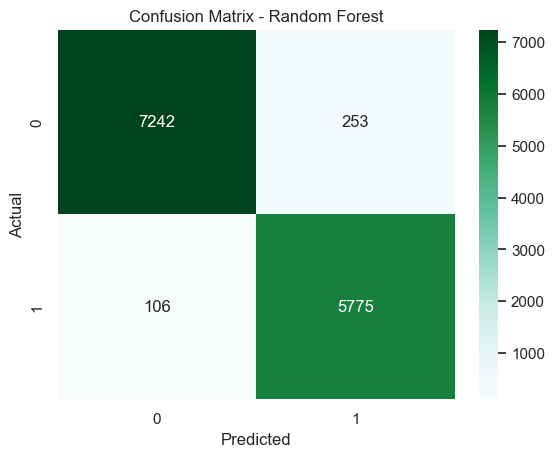

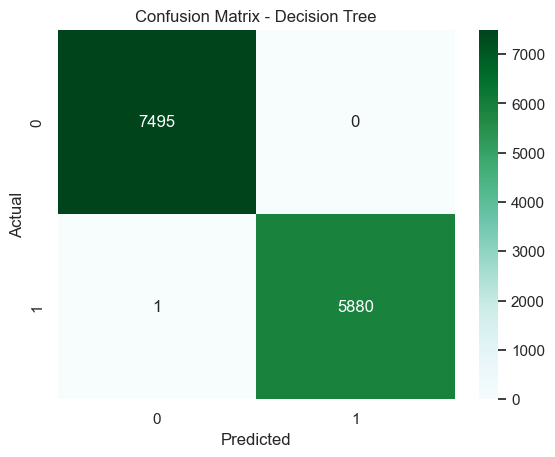

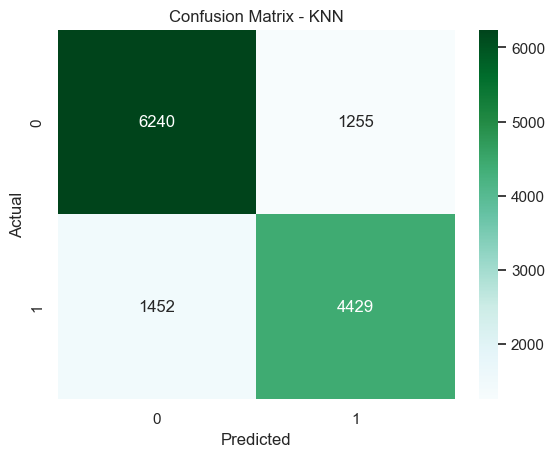

In [7]:
for name, res in results.items():
    cm = confusion_matrix(y_test, res["preds"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## 📊 Model Evaluation Summary

This section compares the performance of all trained models using:

- **AUC Scores**
- **ROC Curves**
- **Leaderboard Ranking**

These metrics help evaluate how well each model distinguishes between **fraud** and **non‑fraud** cases — a critical requirement in insurance fraud detection.

---

### ✅ AUC Score (Area Under ROC Curve)

AUC measures the model’s ability to separate the classes across all thresholds.  
Higher AUC = better fraud detection performance.

---

### ✅ Model Leaderboard

The leaderboard ranks all models based on their AUC scores, from best to worst.

---

### ✅ ROC Curve Comparison

The ROC curve visualizes the trade‑off between **True Positive Rate** and **False Positive Rate** for each model.

A model closer to the **top‑left corner** performs better.

---

AUC Scores:


{'Logistic Regression': 0.9373962962782307,
 'Random Forest': 0.9980487927166544,
 'Decision Tree': 0.999914901040982,
 'KNN': 0.8644645940347468}


Model Leaderboard:


,Model,AUC Score
0,Decision Tree,0.999915
1,Random Forest,0.998049
2,Logistic Regression,0.937396
3,KNN,0.864465


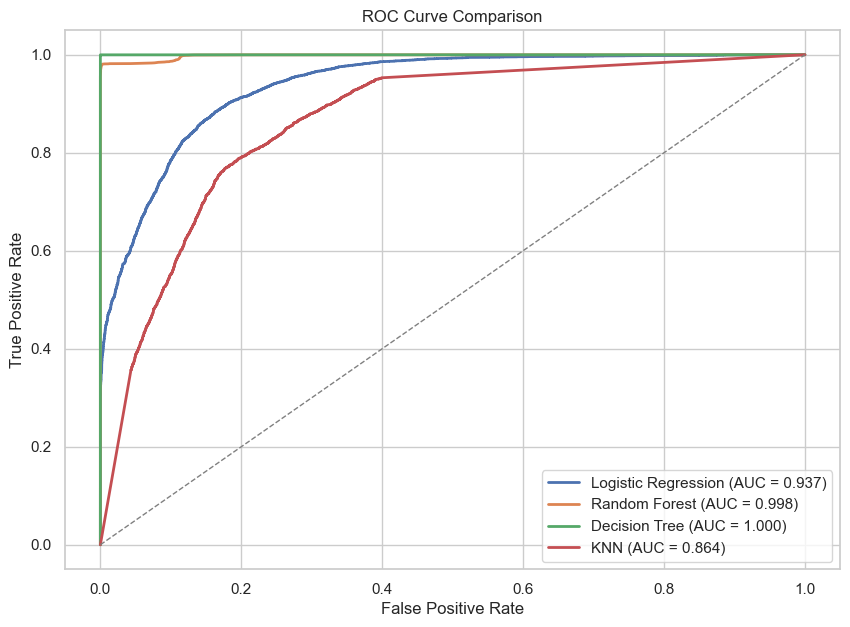

In [14]:
# -----------------------------
# 1. Compute AUC Scores
# -----------------------------
auc_scores = {}

for name, result in results.items():
    auc_scores[name] = roc_auc_score(y_test, result["proba"])

# -----------------------------
# 2. Create Leaderboard
# -----------------------------
leaderboard = pd.DataFrame({
    "Model": list(auc_scores.keys()),
    "AUC Score": list(auc_scores.values())
})

leaderboard = leaderboard.sort_values(by="AUC Score", ascending=False).reset_index(drop=True)

print("AUC Scores:")
display(auc_scores)

print("\nModel Leaderboard:")
display(leaderboard)

# -----------------------------
# 3. Plot ROC Curves
# -----------------------------
plt.figure(figsize=(10, 7))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result["proba"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [25]:
lb = leaderboard.copy()

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')

table = ax.table(
    cellText=lb.values,
    colLabels=lb.columns,
    loc='center',
    cellLoc='center'
)

# Apply colors cell-by-cell
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor("#008080")
        cell.set_text_props(color="white", weight="bold")
    else:
        value = lb.iloc[row-1, col]

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.savefig("../visuals/model_leaderboard.png", dpi=300, bbox_inches='tight')
plt.close()
print("Leaderboard exported as model_leaderboard.png")

Leaderboard exported as model_leaderboard.png


## 💾 Save Best Model (Random Forest Recommended)

In [19]:
import pickle

# Get top-ranked model from leaderboard
best_model_name = leaderboard.loc[0, "Model"]
print("Top-ranked model:", best_model_name)

# Retrieve the model object
best_model = results[best_model_name]["model"]

with open("../models/fraud_detection_model.pkl", "wb") as obj:
    pickle.dump(best_model, obj)

print(f"Best model ({best_model_name}) for Fraud Detection saved successfully!")

Top-ranked model: Decision Tree
Best model (Decision Tree) for Fraud Detection saved successfully!


## ✅ Next Steps

- Integrate the saved model into Flask API (`/predict`)
- Build Streamlit dashboard for fraud prediction
- Deploy end-to-end fraud detection pipeline